## Dual moving average strategy on single asset with stop loss & take profit using vectorbt

We start with a simple hard stop Stop Loss (SL) and Take Profit (TP) mechanism first

- stop loss: 2.5% downside from entry price
- profit target: 5.0% upside from entry price

In [1]:
# dual moving average strategy on single asset
import vectorbt as vbt
import warnings
import matplotlib.pyplot as plt

%matplotlib inline

warnings.filterwarnings("ignore")

### 1. Get price data from yahoo finance

In [9]:
btc_price = vbt.YFData.download("MSFT", start="2020-01-01").get()
btc_close_price = btc_price.Close
print(btc_close_price)

Date
2019-12-31 05:00:00+00:00    152.596512
2020-01-02 05:00:00+00:00    155.422058
2020-01-03 05:00:00+00:00    153.486771
2020-01-06 05:00:00+00:00    153.883514
2020-01-07 05:00:00+00:00    152.480438
                                ...    
2023-08-04 04:00:00+00:00    327.779999
2023-08-07 04:00:00+00:00    330.109985
2023-08-08 04:00:00+00:00    326.049988
2023-08-09 04:00:00+00:00    322.230011
2023-08-10 04:00:00+00:00    322.929993
Name: Close, Length: 909, dtype: float64


### 2. Setup criteria for entry and exit points

In [3]:
SMA12 = vbt.MA.run(btc_close_price, window=12)
SMA24 = vbt.MA.run(btc_close_price, window=24)

In [4]:
entries = SMA12.ma_crossed_above(SMA24)
exits = SMA24.ma_crossed_above(SMA12)

In [74]:
print(f"Length of Entries (array): {entries.vbt.signals.total()}")
print(f"Length of Exits (array): {exits.vbt.signals.total()}")

Length of Entries (array): 19
Length of Exits (array): 20


### 3. Run the backtest

In [5]:
pf = vbt.Portfolio.from_signals(btc_close_price, 
                                entries, exits, 
                                init_cash=1000, # in $1000,
                                fees=0.0025, # in 0.25 % 
                                slippage = 0.0025, # in 0.25 %
                                sl_stop = 0.025, # in 2.5%
                                tp_stop = 0.025, # in 2.5%
                                )

# sl_stop – responsible for % of stop loss. If you’ll pass the value of 0.025 for example it is equal to 2.5%.
# tp_stop – responsible for % of take profit (profit target). The value of 0.05 in my example is equal to 5%.

pf.stats()

Start                         2019-12-31 05:00:00+00:00
End                           2023-08-11 04:00:00+00:00
Period                                              910
Start Value                                      1000.0
End Value                                   1085.235065
Total Return [%]                               8.523506
Benchmark Return [%]                         110.096508
Max Gross Exposure [%]                            100.0
Total Fees Paid                              105.843751
Max Drawdown [%]                               15.74905
Max Drawdown Duration                             408.0
Total Trades                                         19
Total Closed Trades                                  19
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  63.157895
Best Trade [%]                                 5.465119
Worst Trade [%]                               -6

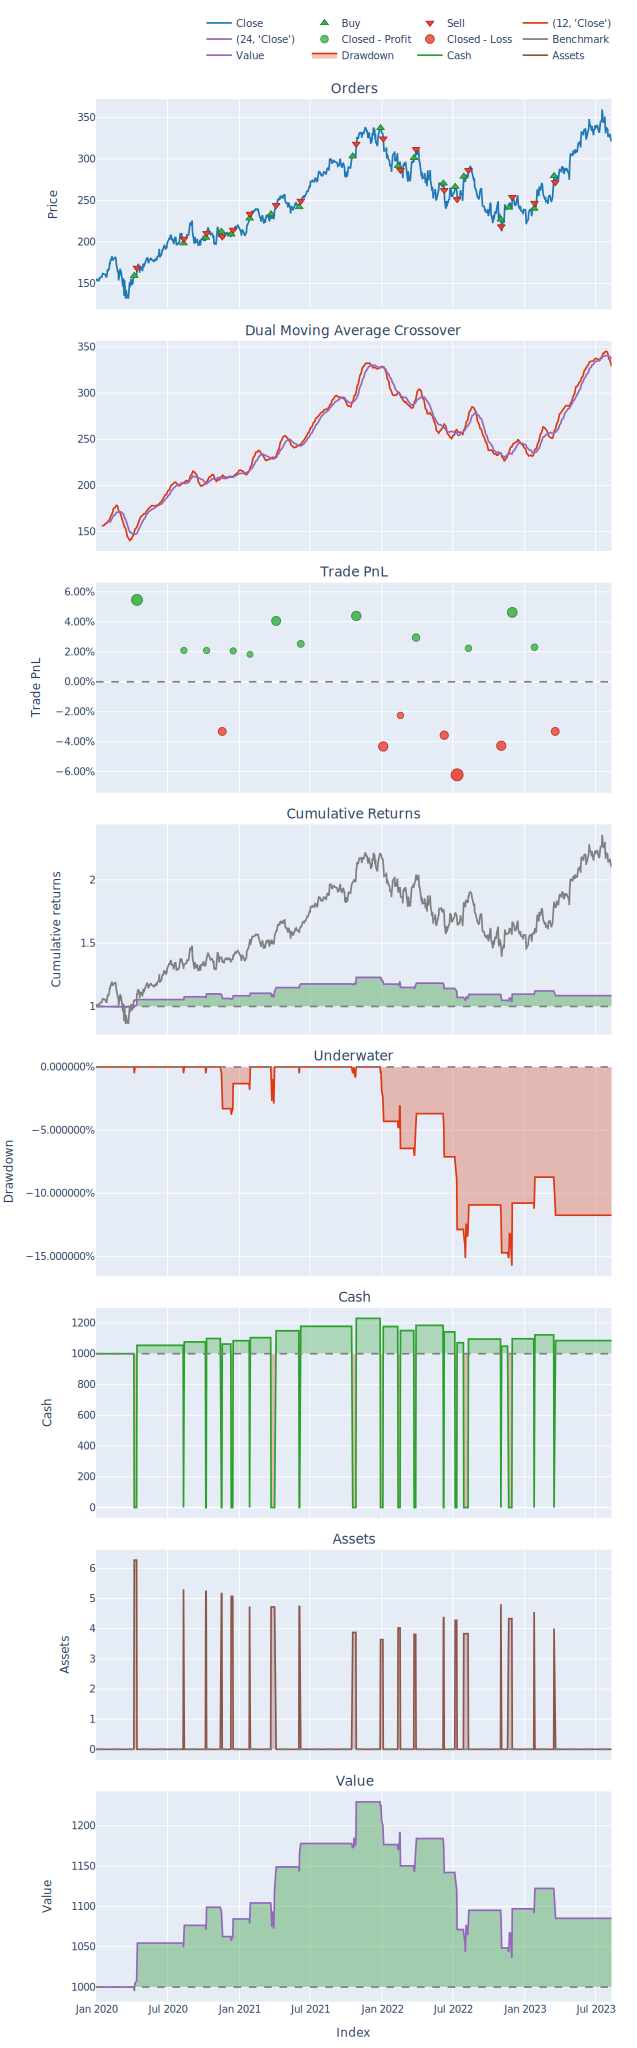

In [56]:
# (Optional) add the dual moving average crossover into the chart
def plot_dmac(portfolio, dmac=None, add_trace_kwargs=None, fig=None):
    #portfolio.orders.plot(add_trace_kwargs=add_trace_kwargs, fig=fig)
    SMA12.ma.vbt.plot(add_trace_kwargs=add_trace_kwargs, fig=fig)
    SMA24.ma.vbt.plot(add_trace_kwargs=add_trace_kwargs, fig=fig)

dmac_subplots = ('dmac', dict(
    title='Dual Moving Average Crossover',
    group_by=False,
    plot_func=plot_dmac
))


# Plot the charts
pf.plot(subplots=["orders", dmac_subplots, "trade_pnl",
                  "cum_returns","underwater",
                  "cash", "assets","value"]).show_svg()